In [102]:
from inference_backend import InferenceSession
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [103]:
path_model = Path(r"..\experiments\2025-01-02_13-37-16\exp02_unet_pvt_v2_b3_lr1e-4_bs16_adamw_None_freeze0\checkpoints/best_model.pth")
session = InferenceSession(model_path=path_model,
                           device_str="cuda:0", threshold=0.5, batch_size=2)

Found config.yaml at ..\experiments\2025-01-02_13-37-16\exp02_unet_pvt_v2_b3_lr1e-4_bs16_adamw_None_freeze0\config.yaml. Loading...
InferenceSession using device: cuda:0
Model loaded from checkpoint. Ready for inference.


In [154]:
def find_center_of_largest_cc (mask):
    mask_binary = (mask.copy() > 0).astype(np.uint8)

    # connectedComponentsWithStats returns:
    #   - num_labels: number of connected components
    #   - labels_im: the label map for each connected component
    #   - stats: statistics for each label (x, y, width, height, area)
    #   - centroids: centroid (x, y) for each label
    num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(mask_binary, connectivity=8)

    largest_area = 0
    largest_label = -1

    # label 0 is the background
    for label in range(1, num_labels):
        area = stats[label, cv2.CC_STAT_AREA]
        if area > largest_area:
            largest_area = area
            largest_label = label

    # Retrieve the centroid of the largest connected component
    # OpenCV returns centroids as (x, y)
    center_x, center_y = centroids[largest_label]
    largest_center = (int(center_y), int(center_x))

    return largest_center

def keep_largest_cc(mask: np.ndarray) -> np.ndarray:
    """
    Given a binary mask, keep only the largest connected component in the mask,
    and set all other pixels to zero.

    Args:
        mask (np.ndarray): A binary mask of shape (H, W), where foreground > 0.

    Returns:
        np.ndarray: A mask of the same shape with only the largest connected
                    component retained (value=1 or >0), other pixels=0.
    """
    # Ensure mask is binarized to {0,1} or {0,255} if needed
    mask_binary = (mask > 0).astype(np.uint8)

    # connectedComponentsWithStats returns:
    #   - num_labels: number of connected components
    #   - labels_im: the label map for each connected component
    #   - stats: statistics for each label (x, y, width, height, area)
    #   - centroids: centroid (x, y) for each label
    num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(mask_binary, connectivity=8)

    # If no foreground is found or only background, return a zero mask
    if num_labels <= 1:
        return np.zeros_like(mask, dtype=mask.dtype)

    # Find the label with the largest area, ignoring label 0 (the background)
    largest_area = 0
    largest_label = -1
    for label in range(1, num_labels):
        area = stats[label, cv2.CC_STAT_AREA]
        if area > largest_area:
            largest_area = area
            largest_label = label

    # Create an output mask that keeps only the largest component
    out_mask = np.zeros_like(mask_binary, dtype=mask_binary.dtype)
    out_mask[labels_im == largest_label] = 1

    # Optionally, cast back to the same type as the original mask
    return out_mask.astype(mask.dtype)

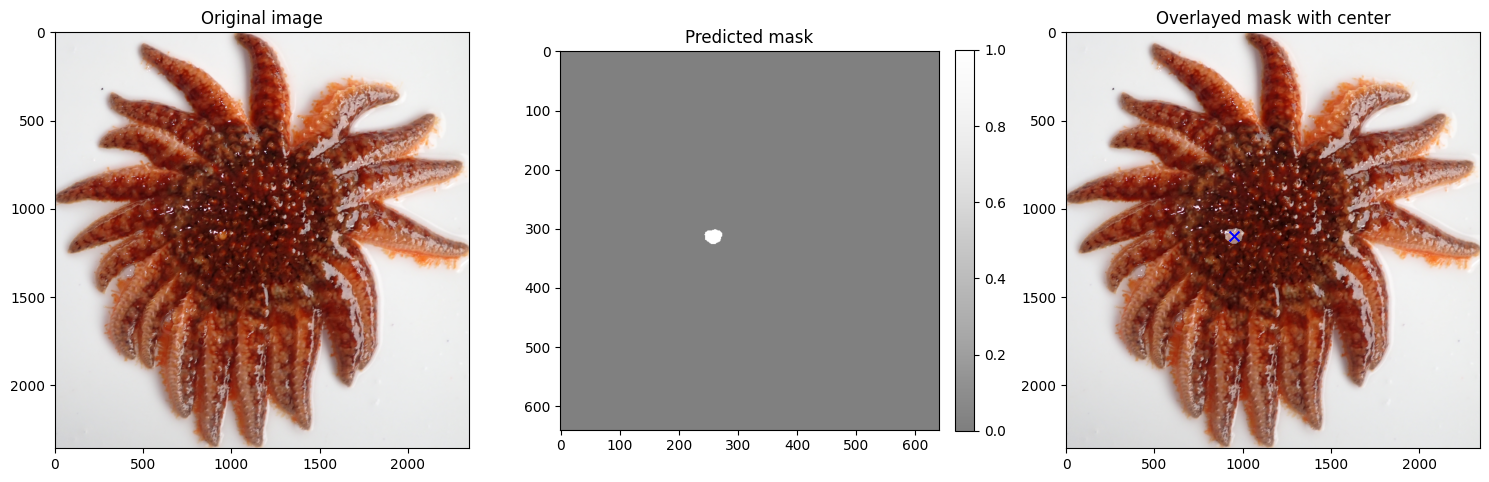

In [151]:
# Single image from a path
path_image = Path(r"demo/SSWD2075_20230904.JPG")
mask1 = session.predict_image(path_image)
# make values beneath the threshold to be 0
mask1[mask1 < 0.5] = 0

fig, axs = plt.subplots(1, 3, figsize=(15,15))

img = cv2.cvtColor(cv2.imread(path_image), cv2.COLOR_BGR2RGB)
axs[0].imshow(img)
axs[0].set_title("Original image")

g = axs[1].imshow(mask1, cmap="Greys_r", alpha=0.5)
## add cbar
plt.colorbar(g, fraction=0.046, pad=0.04)
axs[1].set_title("Predicted mask")

# resize mask to the size of the image
mask1_resized = cv2.resize(mask1, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

# find the center of the largest connected component
center = find_center_of_largest_cc(mask1_resized)

# convert mask to 3 channels
mask1_resized = cv2.merge([mask1_resized, mask1_resized, mask1_resized])
# make 1 values to be 255
mask1_resized = mask1_resized * 255
# convert to rgba for transparency
mask1_resized = cv2.cvtColor(mask1_resized, cv2.COLOR_BGR2RGBA)
# make background pixels to be transparent
mask1_resized[mask1_resized[:, :, 0] == 0] = [0, 0, 0, 0]

# overlay mask on the image within the plot
# have the background pixels in the mask be transparent
axs[2].imshow(img)
axs[2].imshow(mask1_resized, alpha=.5)

# plot the center of the largest connected component
axs[2].scatter(center[1], center[0], c="b", s=50, marker="x")
axs[2].set_title("Overlayed mask with center")

fig.tight_layout()

plt.show()



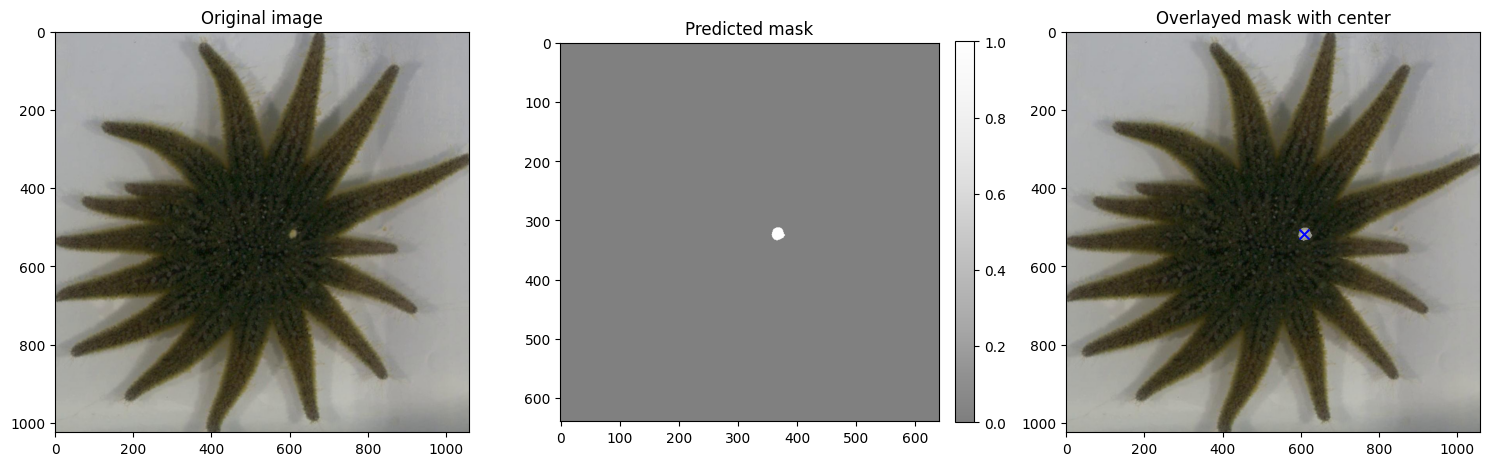

In [152]:
# Single image from a np.array
path_image = Path(r"demo/7716.jpg")
raw_img = cv2.imread(path_image)  # BGR
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
mask2 = session.predict_image(raw_img)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))

axs[0].imshow(raw_img)
axs[0].set_title("Original image")

g = axs[1].imshow(mask2, cmap="Greys_r", alpha=0.5)
## add cbar
plt.colorbar(g, fraction=0.046, pad=0.04)
axs[1].set_title("Predicted mask")

mask2_resized = cv2.resize(mask2, (raw_img.shape[1], raw_img.shape[0]), interpolation=cv2.INTER_NEAREST)
center = find_center_of_largest_cc(mask2_resized)
mask2_resized = cv2.merge([mask2_resized, mask2_resized, mask2_resized])
mask2_resized = mask2_resized * 255
mask2_resized = cv2.cvtColor(mask2_resized, cv2.COLOR_BGR2RGBA)
mask2_resized[mask2_resized[:, :, 0] == 0] = [0, 0, 0, 0]

axs[2].imshow(raw_img)
axs[2].imshow(mask2_resized, alpha=.5)
axs[2].scatter(center[1], center[0], c="b", s=50, marker="x")
axs[2].set_title("Overlayed mask with center")

fig.tight_layout()

plt.show()

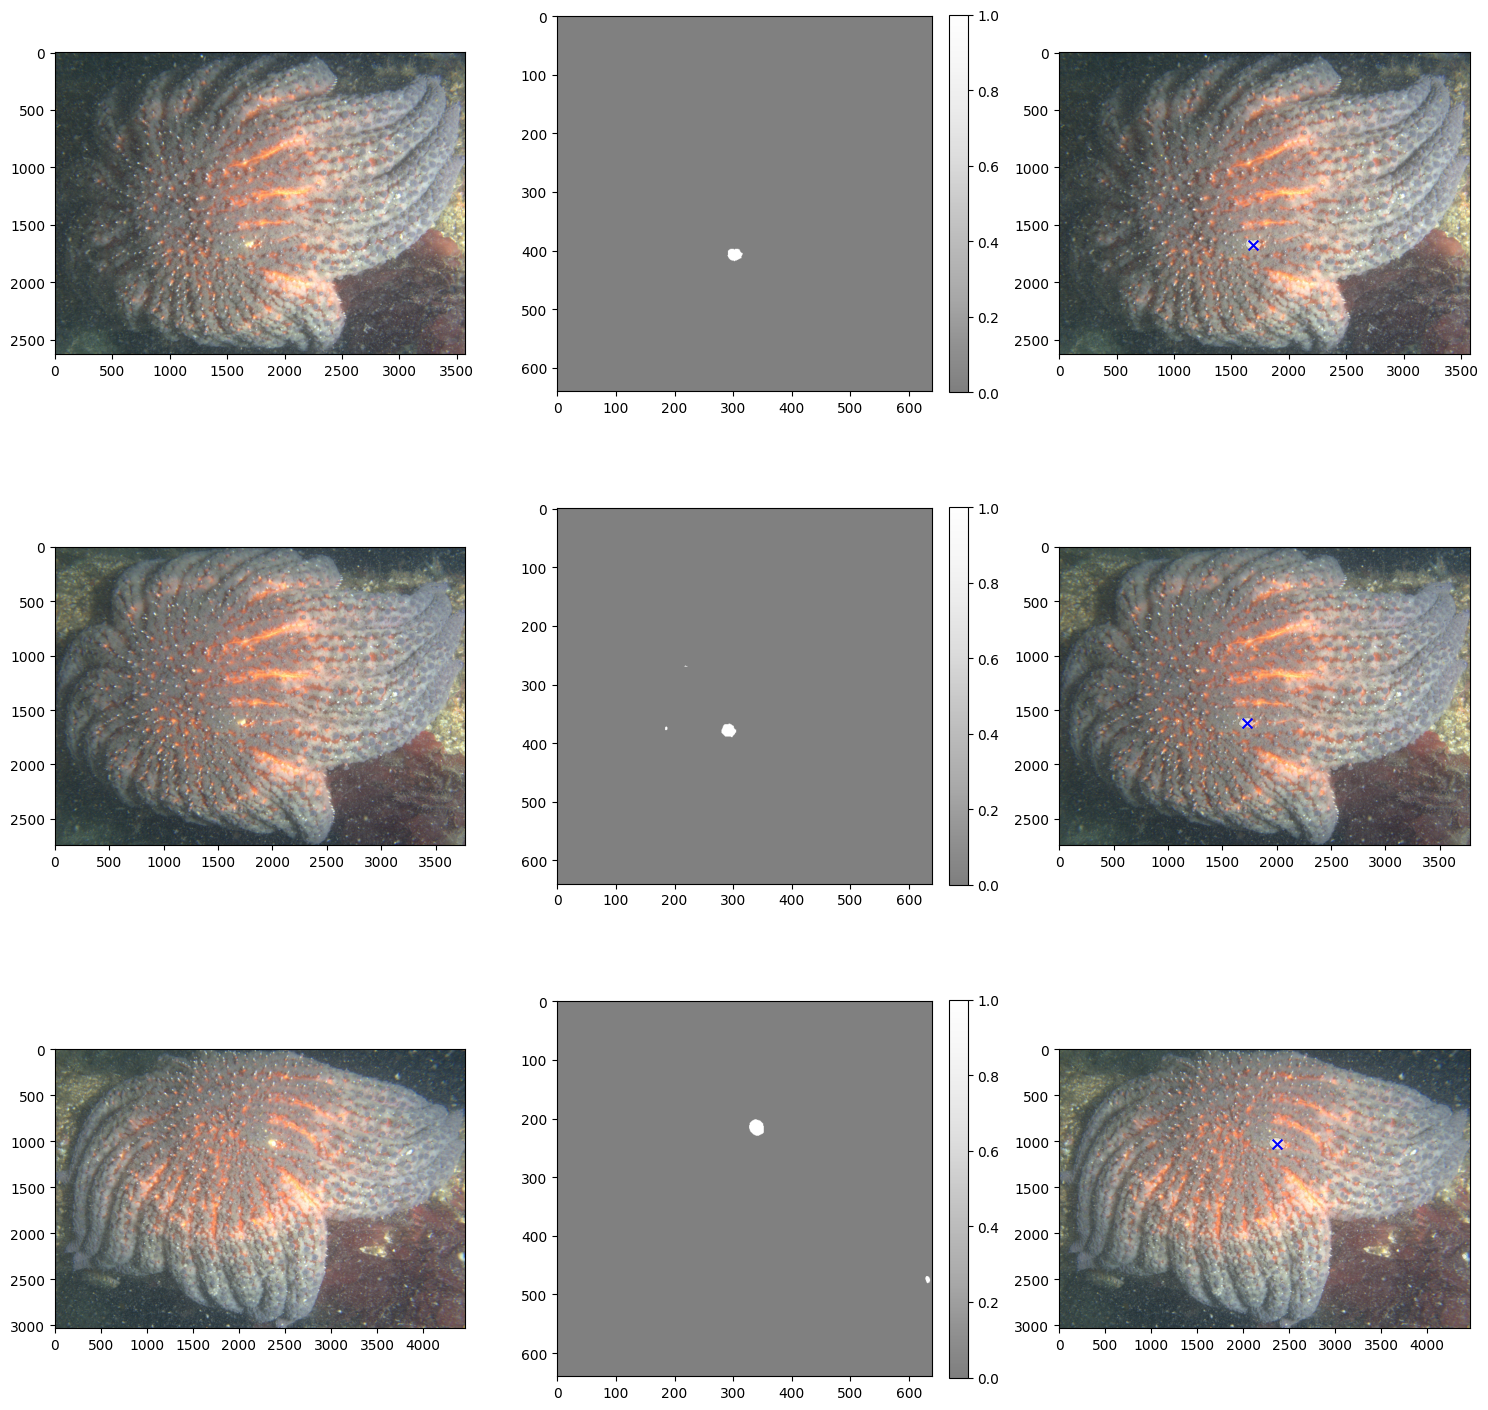

In [107]:
# Many images from paths
image_paths = [Path(r"demo/3516.jpg"), Path(r"demo/3520.jpg"), Path(r"demo/3525.jpg")]
masks = session.predict_images(image_paths)

for mask in masks:
    mask[mask < 0.5] = 0

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, path in enumerate(image_paths):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    axs[i, 0].imshow(img)

    g = axs[i, 1].imshow(masks[i], cmap="Greys_r", alpha=0.5)
    ## add cbar
    plt.colorbar(g, fraction=0.046, pad=0.04)

    mask_resized = cv2.resize(masks[i], (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    center = find_center_of_largest_cc(mask_resized)
    mask_resized = cv2.merge([mask_resized, mask_resized, mask_resized])
    mask_resized = mask_resized * 255
    mask_resized = cv2.cvtColor(mask_resized, cv2.COLOR_BGR2RGBA)
    mask_resized[mask_resized[:, :, 0] == 0] = [0, 0, 0, 0]

    axs[i, 2].imshow(img)
    axs[i, 2].imshow(mask_resized, alpha=.5)
    axs[i, 2].scatter(center[1], center[0], c="b", s=50, marker="x")

fig.tight_layout()

plt.show()

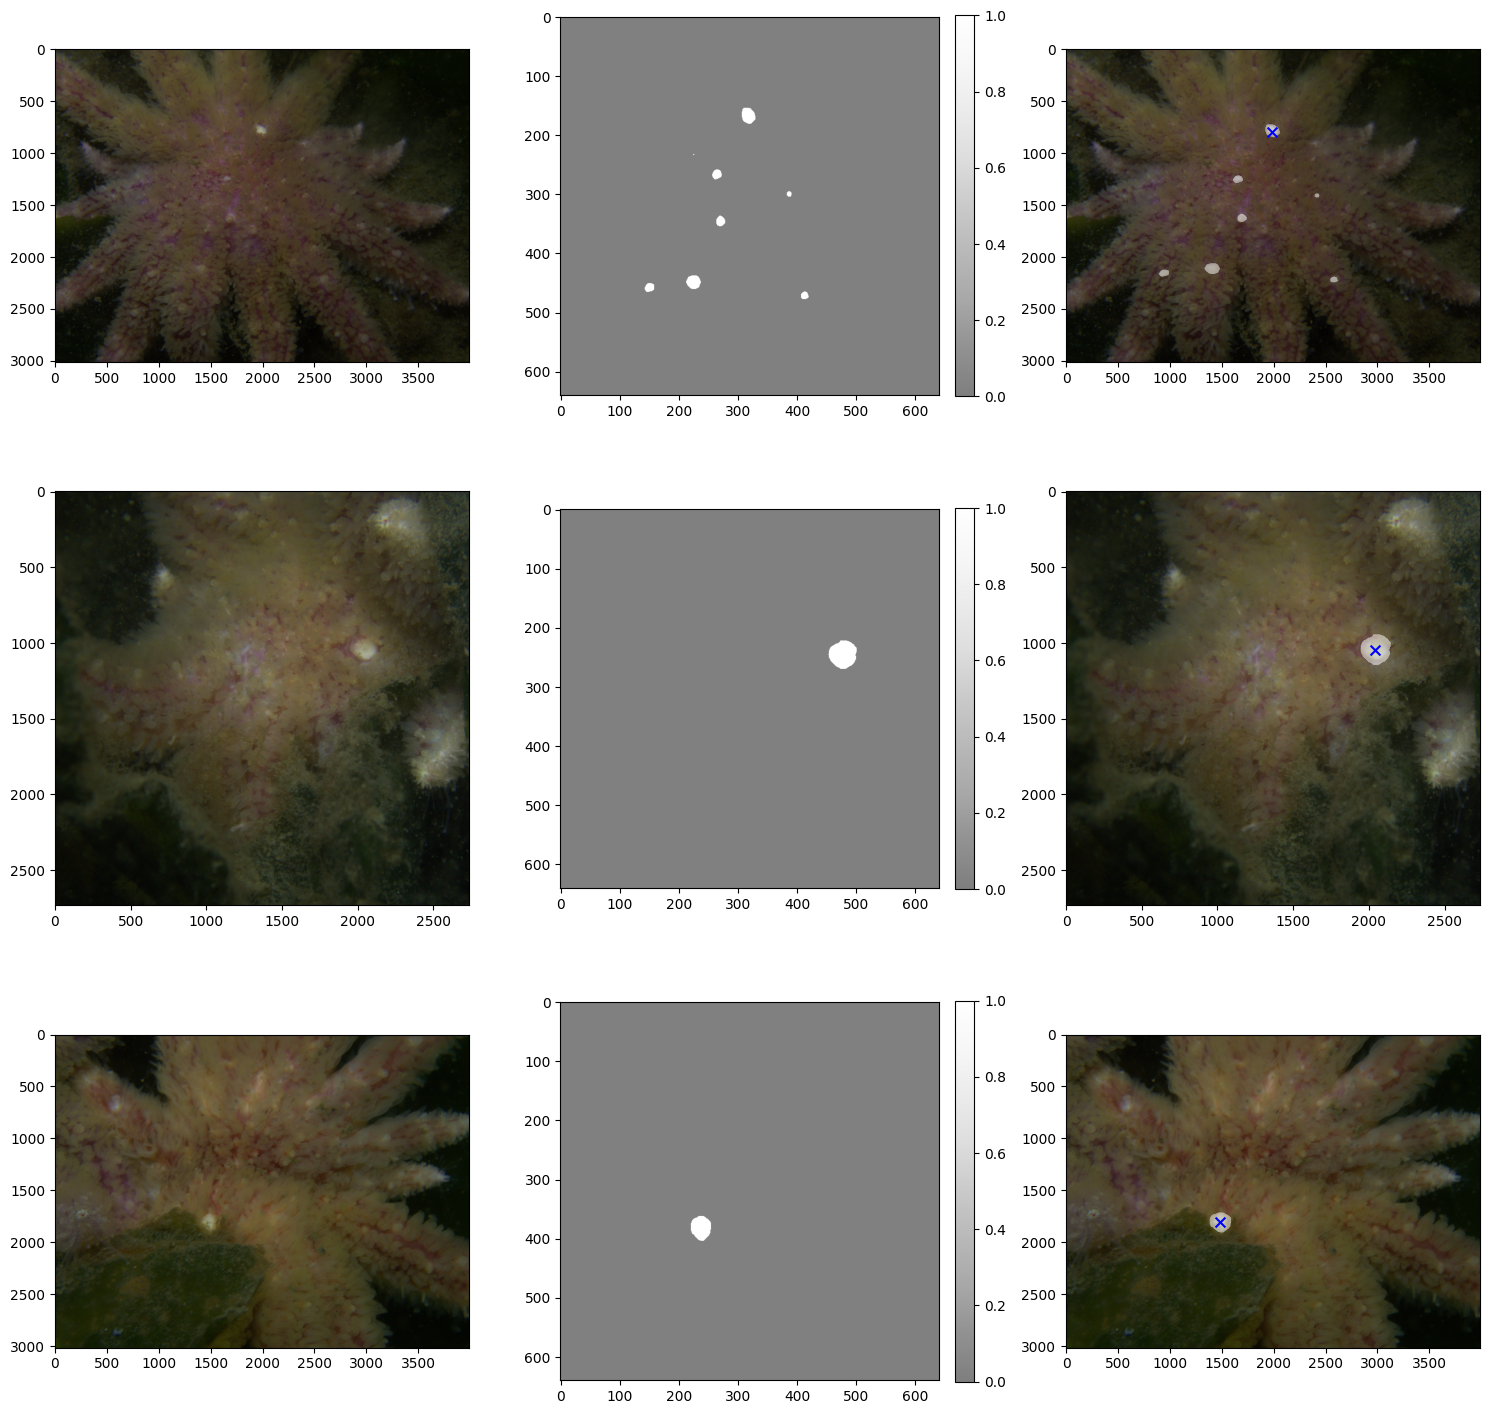

In [108]:
# Or many images from arrays
path_images = [Path(r"demo/6__P8108163.png"), Path(r"demo/7__P8118202.png"), Path(r"demo/11__P8108017.png")]
arrs = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in path_images]
masks2 = session.predict_images(arrs)

for mask in masks2:
    mask[mask < 0.5] = 0

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, arr in enumerate(arrs):
    axs[i, 0].imshow(arr)

    g = axs[i, 1].imshow(masks2[i], cmap="Greys_r", alpha=0.5)
    ## add cbar
    plt.colorbar(g, fraction=0.046, pad=0.04)

    mask_resized = cv2.resize(masks2[i], (arr.shape[1], arr.shape[0]), interpolation=cv2.INTER_NEAREST)
    center = find_center_of_largest_cc(mask_resized)
    mask_resized = cv2.merge([mask_resized, mask_resized, mask_resized])
    mask_resized = mask_resized * 255
    mask_resized = cv2.cvtColor(mask_resized, cv2.COLOR_BGR2RGBA)
    mask_resized[mask_resized[:, :, 0] == 0] = [0, 0, 0, 0]

    axs[i, 2].imshow(arr)
    axs[i, 2].imshow(mask_resized, alpha=.5)
    axs[i, 2].scatter(center[1], center[0], c="b", s=50, marker="x")

fig.tight_layout()

plt.show()

Original image size: (2357, 2346, 3)
Center: (1153, 949)
Half crop size: (266, 267)
Crop: (683, 886),(1215, 1420)
Cropped image size: (534, 532, 3)
Refined mask size: (640, 640)
Refined mask size after resize: (534, 532)


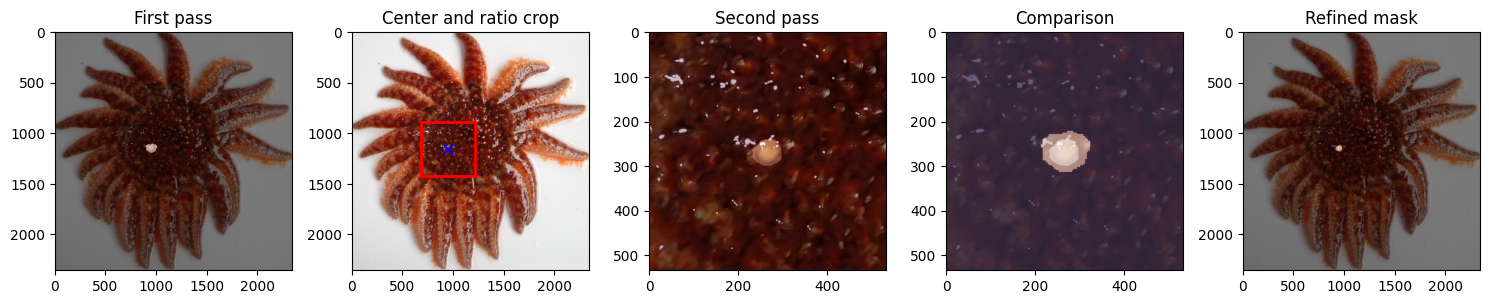

In [155]:
## ok here we show using two passes of the model to improve the results
refinement_ratio = 0.2268 # we will use this ratio of the image size to crop around the center of the mask and use it as the input for the second pass

path_image = Path(r"demo/SSWD2075_20230904.JPG")
original_image = cv2.cvtColor(cv2.imread(path_image), cv2.COLOR_BGR2RGB)
mask = session.predict_image(original_image)
mask[mask < 0.5] = 0

mask_resized = cv2.resize(mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)
center = find_center_of_largest_cc(mask_resized)

# crop around the center of the mask
h, w = original_image.shape[:2]
half_crop_w = int(w * refinement_ratio / 2)
half_crop_h = int(h * refinement_ratio / 2)

x0 = center[1] - half_crop_w
x1 = center[1] + half_crop_w
y0 = center[0] - half_crop_h
y1 = center[0] + half_crop_h

# Clamp to image edges if needed:
x0 = max(0, x0)
y0 = max(0, y0)
x1 = min(w, x1)
y1 = min(h, y1)

print(f'Original image size: {original_image.shape}')
print(f'Center: {center}')
print(f'Half crop size: ({half_crop_w}, {half_crop_h})')
print(f'Crop: ({x0}, {y0}),({x1}, {y1})')

cropped_image = original_image[y0:y1, x0:x1]
print(f'Cropped image size: {cropped_image.shape}')

refined_mask = session.predict_image(cropped_image)
refined_mask[refined_mask < 0.5] = 0
print(f'Refined mask size: {refined_mask.shape}')

## only keep the largest connected component
refined_mask = keep_largest_cc(refined_mask)

## cast the mask back to the cropped image size
refined_mask = cv2.resize(refined_mask, (half_crop_w * 2, half_crop_h * 2), interpolation=cv2.INTER_NEAREST)
print(f'Refined mask size after resize: {refined_mask.shape}')
## we paste the refined mask onto a black image of the original size
cast_refined_mask = np.zeros(original_image.shape[:2], dtype=np.float32)
cast_refined_mask[y0:y1, x0:x1] = refined_mask

fig, axs = plt.subplots(1, 5, figsize=(15, 15))

axs[0].imshow(original_image)
axs[0].imshow(mask_resized, cmap="Greys_r", alpha=0.5)
axs[0].set_title("First pass")

axs[1].imshow(original_image)
axs[1].add_patch(plt.Rectangle((x0, y0), half_crop_w * 2, half_crop_h * 2, fill=False, edgecolor='r', lw=2))
axs[1].scatter(center[1], center[0], c="b", s=50, marker="x")
axs[1].set_title("Center and ratio crop")

axs[2].imshow(cropped_image)
axs[2].imshow(refined_mask, cmap="Greys_r", alpha=0.25)
axs[2].set_title("Second pass")

axs[3].imshow(cropped_image)
axs[3].imshow(refined_mask, cmap="Oranges_r", alpha=0.5)
cropped_unrefined_mask = mask_resized[y0:y1, x0:x1]
axs[3].imshow(cropped_unrefined_mask, cmap="Blues_r", alpha=0.5)
axs[3].set_title("Comparison")

axs[4].imshow(original_image)
axs[4].imshow(cast_refined_mask, cmap="Greys_r", alpha=0.5)
axs[4].set_title("Refined mask")

fig.tight_layout()

plt.show()
